# Workflow

## Imports and Functions

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def generate_copy_data(num_samples, T, vocab_size):
    seq_length = 2 * T + 1
    X = np.zeros((num_samples, seq_length), dtype=np.int64)
    Y = np.zeros((num_samples, seq_length), dtype=np.int64)

    delimiter_token = vocab_size + 1

    for i in range(num_samples):
        random_seq = np.random.randint(1, vocab_size + 1, size=T)
        X[i, :T] = random_seq
        X[i, T]  = delimiter_token
        # T zeros follow automatically from initialization
        Y[i, T+1:] = random_seq

    return X, Y

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for batch_x, batch_y in dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        logits = model(batch_x)
        batch_size, seq_length, vocab_dim = logits.shape

        logits_2d = logits.view(batch_size * seq_length, vocab_dim)
        targets_1d = batch_y.view(batch_size * seq_length)

        loss = criterion(logits_2d, targets_1d)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_size

        with torch.no_grad():
            preds = logits_2d.argmax(dim=-1)
            correct = (preds == targets_1d).sum().item()
            total_correct += correct
            total_samples += batch_size * seq_length

    avg_loss = total_loss / len(dataloader.dataset)
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            logits = model(batch_x)
            batch_size, seq_length, vocab_dim = logits.shape

            logits_2d = logits.view(batch_size * seq_length, vocab_dim)
            targets_1d = batch_y.view(batch_size * seq_length)

            loss = criterion(logits_2d, targets_1d)
            total_loss += loss.item() * batch_size

            preds = logits_2d.argmax(dim=-1)
            correct = (preds == targets_1d).sum().item()
            total_correct += correct
            total_samples += batch_size * seq_length

    avg_loss = total_loss / len(dataloader.dataset)
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc


## CELLS and MODELS

### Standard LSTM Class

In [3]:
class StandardLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(StandardLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.W_i = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.01)
        self.U_i = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.01)
        self.b_i = nn.Parameter(torch.zeros(hidden_dim))

        self.W_f = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.01)
        self.U_f = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.01)
        self.b_f = nn.Parameter(torch.zeros(hidden_dim))

        self.W_o = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.01)
        self.U_o = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.01)
        self.b_o = nn.Parameter(torch.zeros(hidden_dim))

        self.W_c = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.01)
        self.U_c = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.01)
        self.b_c = nn.Parameter(torch.zeros(hidden_dim))

    def forward(self, x, h_prev, c_prev):

        i_t = torch.sigmoid(x @ self.W_i + h_prev @ self.U_i + self.b_i)
        f_t = torch.sigmoid(x @ self.W_f + h_prev @ self.U_f + self.b_f)
        o_t = torch.sigmoid(x @ self.W_o + h_prev @ self.U_o + self.b_o)
        c_hat_t = torch.tanh(x @ self.W_c + h_prev @ self.U_c + self.b_c)
        c_t = f_t * c_prev + i_t * c_hat_t
        h_t = o_t * torch.tanh(c_t)
        return h_t, c_t


class StandardLSTMModel(nn.Module):

    def __init__(self, vocab_size, hidden_size):
        super(StandardLSTMModel, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(num_embeddings=vocab_size + 2, embedding_dim=hidden_size)
        self.lstm_cell = StandardLSTMCell(input_dim=hidden_size, hidden_dim=hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size + 1)

    def forward(self, x):
        batch_size, seq_length = x.shape
        embedded = self.embedding(x)

        h = torch.zeros(batch_size, self.hidden_size, device=embedded.device)
        c = torch.zeros(batch_size, self.hidden_size, device=embedded.device)

        outputs = []

        for t in range(seq_length):
            x_t = embedded[:, t, :]
            h, c = self.lstm_cell(x_t, h, c)
            outputs.append(h.unsqueeze(1))

        outputs = torch.cat(outputs, dim=1)
        logits = self.fc(outputs)
        return logits

### Multiplicative LSTM Class

In [4]:
class MultiplicativeLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MultiplicativeLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.W_m = nn.Parameter(torch.randn(input_dim, input_dim)*0.01)
        self.U_m = nn.Parameter(torch.randn(hidden_dim, input_dim)*0.01)
        self.b_m = nn.Parameter(torch.zeros(input_dim))

        self.W_i = nn.Parameter(torch.randn(input_dim, hidden_dim)*0.01)
        self.U_i = nn.Parameter(torch.randn(hidden_dim, hidden_dim)*0.01)
        self.b_i = nn.Parameter(torch.zeros(hidden_dim))

        self.W_f = nn.Parameter(torch.randn(input_dim, hidden_dim)*0.01)
        self.U_f = nn.Parameter(torch.randn(hidden_dim, hidden_dim)*0.01)
        self.b_f = nn.Parameter(torch.zeros(hidden_dim))

        self.W_o = nn.Parameter(torch.randn(input_dim, hidden_dim)*0.01)
        self.U_o = nn.Parameter(torch.randn(hidden_dim, hidden_dim)*0.01)
        self.b_o = nn.Parameter(torch.zeros(hidden_dim))

        self.W_c = nn.Parameter(torch.randn(input_dim, hidden_dim)*0.01)
        self.U_c = nn.Parameter(torch.randn(hidden_dim, hidden_dim)*0.01)
        self.b_c = nn.Parameter(torch.zeros(hidden_dim))

    def forward(self, x, h_prev, c_prev):

        m_t = x @ self.W_m + h_prev @ self.U_m + self.b_m
        x_tilde = m_t * x
        i_t = torch.sigmoid(x_tilde @ self.W_i + h_prev @ self.U_i + self.b_i)
        f_t = torch.sigmoid(x_tilde @ self.W_f + h_prev @ self.U_f + self.b_f)
        o_t = torch.sigmoid(x_tilde @ self.W_o + h_prev @ self.U_o + self.b_o)
        c_hat_t = torch.tanh(x_tilde @ self.W_c + h_prev @ self.U_c + self.b_c)
        c_t = f_t * c_prev + i_t * c_hat_t
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t


class MultiplicativeLSTMModel(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(MultiplicativeLSTMModel, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(num_embeddings=vocab_size + 2, embedding_dim=hidden_size)
        self.lstm_cell = MultiplicativeLSTMCell(input_dim=hidden_size, hidden_dim=hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size + 1)

    def forward(self, x):
        batch_size, seq_length = x.shape

        embedded = self.embedding(x)

        h = torch.zeros(batch_size, self.hidden_size, device=embedded.device)
        c = torch.zeros(batch_size, self.hidden_size, device=embedded.device)

        outputs = []
        for t in range(seq_length):
            x_t = embedded[:, t, :]
            h, c = self.lstm_cell(x_t, h, c)
            outputs.append(h.unsqueeze(1))

        outputs = torch.cat(outputs, dim=1)
        logits = self.fc(outputs)
        return logits

### Standard GRU Class

In [5]:
class StandardGRUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(StandardGRUCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.W_z = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.01)
        self.U_z = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.01)
        self.b_z = nn.Parameter(torch.zeros(hidden_dim))

        self.W_r = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.01)
        self.U_r = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.01)
        self.b_r = nn.Parameter(torch.zeros(hidden_dim))

        self.W_h = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.01)
        self.U_h = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.01)
        self.b_h = nn.Parameter(torch.zeros(hidden_dim))

    def forward(self, x_t, h_prev):

        z_t = torch.sigmoid(x_t @ self.W_z + h_prev @ self.U_z + self.b_z)
        r_t = torch.sigmoid(x_t @ self.W_r + h_prev @ self.U_r + self.b_r)
        h_hat_t = torch.tanh(x_t @ self.W_h + (r_t * h_prev) @ self.U_h + self.b_h)
        h_t = (1 - z_t) * h_prev + z_t * h_hat_t

        return h_t


class StandardGRUModel(nn.Module):

    def __init__(self, vocab_size, hidden_size):
        super(StandardGRUModel, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(num_embeddings=vocab_size + 2, embedding_dim=hidden_size)
        self.gru_cell = StandardGRUCell(input_dim=hidden_size, hidden_dim=hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size + 1)

    def forward(self, x):
        batch_size, seq_length = x.shape
        embedded = self.embedding(x)

        h = torch.zeros(batch_size, self.hidden_size, device=embedded.device)

        outputs = []
        for t in range(seq_length):
            x_t = embedded[:, t, :]
            h = self.gru_cell(x_t, h)
            outputs.append(h.unsqueeze(1))

        outputs = torch.cat(outputs, dim=1)
        logits = self.fc(outputs)
        return logits


### Multiplicative GRU Class

In [6]:
class MultiplicativeGRUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MultiplicativeGRUCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.W_m = nn.Parameter(torch.randn(input_dim, input_dim)*0.01)
        self.U_m = nn.Parameter(torch.randn(hidden_dim, input_dim)*0.01)
        self.b_m = nn.Parameter(torch.zeros(input_dim))

        self.W_z = nn.Parameter(torch.randn(input_dim, hidden_dim)*0.01)
        self.U_z = nn.Parameter(torch.randn(hidden_dim, hidden_dim)*0.01)
        self.b_z = nn.Parameter(torch.zeros(hidden_dim))

        self.W_r = nn.Parameter(torch.randn(input_dim, hidden_dim)*0.01)
        self.U_r = nn.Parameter(torch.randn(hidden_dim, hidden_dim)*0.01)
        self.b_r = nn.Parameter(torch.zeros(hidden_dim))

        self.W_h = nn.Parameter(torch.randn(input_dim, hidden_dim)*0.01)
        self.U_h = nn.Parameter(torch.randn(hidden_dim, hidden_dim)*0.01)
        self.b_h = nn.Parameter(torch.zeros(hidden_dim))

    def forward(self, x_t, h_prev):

        m_t = x_t @ self.W_m + h_prev @ self.U_m + self.b_m
        x_tilde = m_t * x_t
        z_t = torch.sigmoid(x_tilde @ self.W_z + h_prev @ self.U_z + self.b_z)
        r_t = torch.sigmoid(x_tilde @ self.W_r + h_prev @ self.U_r + self.b_r)
        h_hat_t = torch.tanh(x_tilde @ self.W_h + (r_t * h_prev) @ self.U_h + self.b_h)
        h_t = (1 - z_t) * h_prev + z_t * h_hat_t

        return h_t


class MultiplicativeGRUModel(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(MultiplicativeGRUModel, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(num_embeddings=vocab_size + 2, embedding_dim=hidden_size)
        self.gru_cell = MultiplicativeGRUCell( input_dim=hidden_size, hidden_dim=hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size + 1)

    def forward(self, x):
        batch_size, seq_length = x.shape
        embedded = self.embedding(x)

        h = torch.zeros(batch_size, self.hidden_size, device=embedded.device)

        outputs = []
        for t in range(seq_length):
            x_t = embedded[:, t, :]
            h = self.gru_cell(x_t, h)
            outputs.append(h.unsqueeze(1))

        outputs = torch.cat(outputs, dim=1)
        logits = self.fc(outputs)
        return logits


## Training and Logging

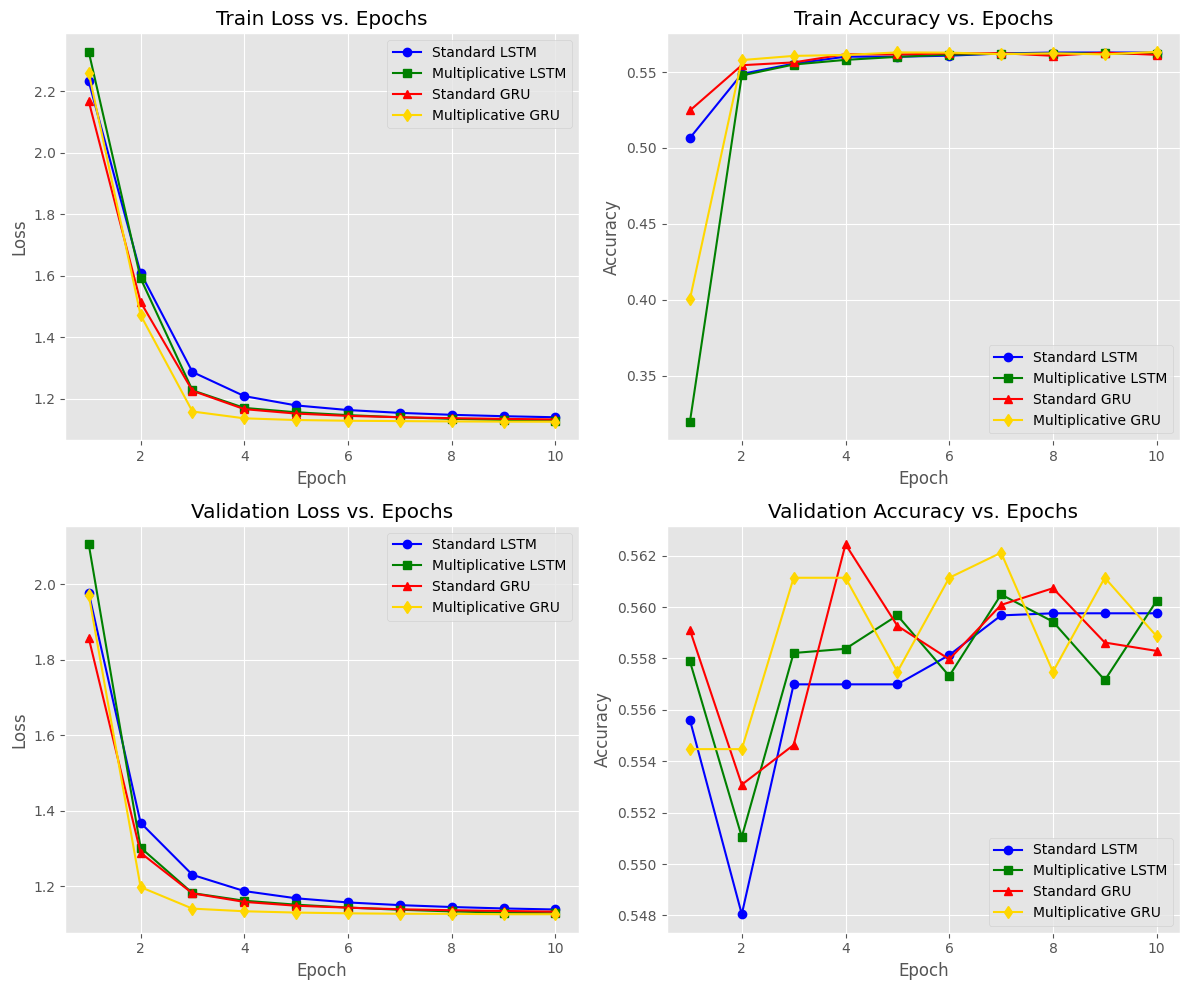

In [21]:
#  Hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(123)

vocab_size  = 10
hidden_size = 50
num_samples = 1000
T_train     = 20
batch_size  = 50
epochs      = 10

# Data Preparation
X, Y = generate_copy_data(num_samples, T_train, vocab_size)
split_idx = int(num_samples * 0.7)
X_train_np, Y_train_np = X[:split_idx], Y[:split_idx]
X_val_np,   Y_val_np   = X[split_idx:], Y[split_idx:]

X_train_t = torch.from_numpy(X_train_np)
Y_train_t = torch.from_numpy(Y_train_np)
X_val_t   = torch.from_numpy(X_val_np)
Y_val_t   = torch.from_numpy(Y_val_np)

train_dataset = torch.utils.data.TensorDataset(X_train_t, Y_train_t)
val_dataset   = torch.utils.data.TensorDataset(X_val_t,   Y_val_t)
train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader    = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#  Define 4 Models
models_dict = {
    'Standard LSTM':         {
        'model':  StandardLSTMModel(vocab_size, hidden_size).to(device),
        'history': [],
        'color':  'blue',
        'marker': 'o'
    },
    'Multiplicative LSTM':   {
        'model':  MultiplicativeLSTMModel(vocab_size, hidden_size).to(device),
        'history': [],
        'color':  'green',
        'marker': 's'
    },
    'Standard GRU':          {
        'model':  StandardGRUModel(vocab_size, hidden_size).to(device),
        'history': [],
        'color':  'red',
        'marker': '^'
    },
    'Multiplicative GRU':    {
        'model':  MultiplicativeGRUModel(vocab_size, hidden_size).to(device),
        'history': [],
        'color':  'gold',
        'marker': 'd'
    }
}

#  Prepare CSV logger
log_filename = "training_log.csv"
with open(log_filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["epoch", "model_name", "train_loss", "train_acc", "val_loss", "val_acc"])

    for model_name, info in models_dict.items():
        for epoch in range(1, epochs+1):
            model = info['model']
            optimizer = optim.Adam(model.parameters(), lr=1e-3)
            if 'optimizer' not in info:
                info['optimizer'] = optim.Adam(model.parameters(), lr=1e-3)
            train_loss, train_acc = train_one_epoch( model, train_loader, nn.CrossEntropyLoss(), info['optimizer'], device)
            val_loss,   val_acc   = evaluate( model, val_loader, nn.CrossEntropyLoss(), device)
            info['history'].append((train_loss, train_acc, val_loss, val_acc))
            writer.writerow([epoch, model_name, train_loss, train_acc, val_loss, val_acc])

#  Plot the curves
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].set_title("Train Loss vs. Epochs")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")

axes[0, 1].set_title("Train Accuracy vs. Epochs")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Accuracy")

axes[1, 0].set_title("Validation Loss vs. Epochs")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Loss")

axes[1, 1].set_title("Validation Accuracy vs. Epochs")
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Accuracy")

for model_name, info in models_dict.items():
    train_losses = [h[0] for h in info['history']]
    train_accs   = [h[1] for h in info['history']]
    val_losses   = [h[2] for h in info['history']]
    val_accs     = [h[3] for h in info['history']]
    epochs = range(1, len(train_losses) + 1)
    axes[0, 0].plot(epochs, train_losses, label=model_name, color=info['color'], marker=info['marker'])
    axes[0, 1].plot(epochs, train_accs, label=model_name, color=info['color'], marker=info['marker'])
    axes[1, 0].plot(epochs, val_losses, label=model_name, color=info['color'], marker=info['marker'])
    axes[1, 1].plot(epochs, val_accs, label=model_name, color=info['color'], marker=info['marker'])
for ax in axes.flat:
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()

## Testing and Showcase

In [17]:
T_values = [100, 200, 500, 1000]
num_test_samples = 20

accuracy_matrix = pd.DataFrame(0.0, index=list(models_dict.keys()), columns=T_values)

for T in T_values:
    X_test_np, Y_test_np = generate_copy_data(num_test_samples, T, vocab_size)
    seq_length = X_test_np.shape[1]

    X_test_t = torch.from_numpy(X_test_np).to(device)
    Y_test_t = torch.from_numpy(Y_test_np).to(device)

    for model_name, info in models_dict.items():
        model = info['model']
        model.eval()
        with torch.no_grad():
            logits = model(X_test_t)
            preds = logits.argmax(dim=-1)

        correct_tokens = (preds == Y_test_t).sum().item()
        total_tokens   = preds.numel()
        accuracy       = correct_tokens / total_tokens

        accuracy_matrix.loc[model_name, T] = accuracy

print("=== Accuracy Matrix ===")
print(accuracy_matrix)


=== Accuracy Matrix ===
                         100       200       500       1000
Standard LSTM        0.549254  0.552120  0.550050  0.549300
Multiplicative LSTM  0.552985  0.556608  0.552897  0.549075
Standard GRU         0.556219  0.548130  0.551249  0.550650
Multiplicative GRU   0.547015  0.552993  0.553197  0.548976


In [20]:
def token_to_char(token_id):
    """
    Map:
      0 -> '0'
      1..10 -> 'A'..'J'
      11 -> '='
      (Any others, just convert to string)
    """
    if token_id == 0:
        return '0'
    elif 1 <= token_id <= 10:
        return chr(ord('A') + (token_id - 1))
    elif token_id == 11:
        return '='
    else:
        return str(token_id)

T_showcase = 50
num_showcase_samples = 2

X_show_np, Y_show_np = generate_copy_data(num_showcase_samples, T_showcase, vocab_size)
seq_length_show = X_show_np.shape[1]

X_show_t = torch.from_numpy(X_show_np).to(device)

with open("showcase.txt", "w") as f:
    for model_name, info in models_dict.items():
        model = info['model']
        model.eval()
        with torch.no_grad():
            logits = model(X_show_t)
            preds = logits.argmax(dim=-1).cpu().numpy()

        for i in range(num_showcase_samples):
            input_nums     = X_show_np[i].tolist()
            expected_nums  = Y_show_np[i].tolist()
            predicted_nums = preds[i].tolist()

            input_letters     = [token_to_char(t) for t in input_nums]
            expected_letters  = [token_to_char(t) for t in expected_nums]
            predicted_letters = [token_to_char(t) for t in predicted_nums]

            f.write(f"=== Model: {model_name}, Sample #{i+1} (T={T_showcase}) ===\n")
            f.write("1) Plain text input : " + "".join(input_letters) + "\n")
            f.write("2) Converted input  : " + str(input_nums) + "\n")
            f.write("3) Model output     : " + str(predicted_nums) + "\n")
            f.write("4) Plain text output: " + "".join(predicted_letters) + "\n")
            f.write("5) Expected output  : " + "".join(expected_letters) + "\n")
            f.write("\n")

print("Showcase for T=20 has been written to showcase.txt.")


Showcase for T=20 has been written to showcase.txt.
